# Catégorisez les produits d'un site d'e-commerce: Extraction des features images

* [1. Import et chargement des données](#10)
    * [1.1 Import des librairies](#11)
    * [1.2 Chargement des données](#12)
    * [1.3 Transformation des labels](#13)
* [2. Extraction des features avec un CNN](#20)
    * [2.1 Chargement du modèle VGG16](#21)
    * [2.2 Extraction des features](#22)
    * [2.3 Réduction des dimensions](#23)
    * [2.4 Classification non-supervisée des features](#24)
* [3. Extraction des features avec SIFT](#30)
    * [3.1 Préparation du modèle SIFT](#31)
    * [3.2 Extraction des points d'intéret](#32)
    * [4.3 Réduction des dimensions](#33)
    * [4.4 Classification non-supervisée des points d'intéret](#34)
* [4. Conclusion](#40)

<h1 id="10">1. Import et chargement des données</h1>

<h2 id="11">1.1 Import des librairies</h2>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [3]:
image_path = os.getcwd() + "\\flipkart\\images\\"

<h2 id='12'>1.2 Chargement des données</h2>

In [4]:
df = pd.read_csv("flipkart\\flipkart_com-ecommerce_sample_1050.csv")
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


<h2 id='13'>1.3 Transformation des labels</h2>

In [5]:
df["main_category"] = df['product_category_tree'].str.split(" >> ").str[0].str.replace('["', '')
df['main_category'].value_counts()

main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [6]:
df["main_category"].nunique()

7

<h1 id='20'>2. Extraction des features avec un CNN</h1>

<h2 id='21'>2.1 Chargement du modèle VGG16</h2>

In [7]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-3].output)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,479,232 (448.15 MB)

 Trainable params: 117,479,232 (448.15 MB)

 Non-trainable params: 0 (0.00 B)

None


<h2 id='22'>2.2 Extraction des features</h2>

In [8]:
images_features = []
 
for i, image_file in enumerate(df["image"]):
    if i%100 == 0 : print(f"{i} images have been preprocessed")

    image = load_img(image_path + image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

#def load_images(path) -> list:
#    image = load_img(image_file, target_size=(224,224))
#    image = img_to_array(image)
#    image = np.expand_dims(image, 0)
#    image = preprocess_input(image)
#
#    return image

#def extract_features(image):
#    images_features = model.predict(image, verbose=0)[0]
#
#    return images_features

0


c:\Users\apetit\anaconda3\envs\flipkart\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


100
200
300
400
500
600


c:\Users\apetit\anaconda3\envs\flipkart\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


(1050, 4096)

<h2 id='23'>2.3 Réduction des dimensions</h2>

In [9]:
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



c:\Users\apetit\anaconda3\envs\flipkart\Lib\site-packages\IPython\core\completerlib.py:150: UserWarning: This is now an optional IPython functionality, setting rootmodules_cache requires you to install the `pickleshare` library.
  ip.db['rootmodules_cache'] = rootmodules_cache


(1050, 856)


In [10]:
from time import perf_counter

start = perf_counter()

tsne = TSNE(n_components=2, perplexity=30, max_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration = perf_counter() - start
print(f"temps de T-SNE : {duration:.0f} secondes")

temps de T-SNE : 15 secondes


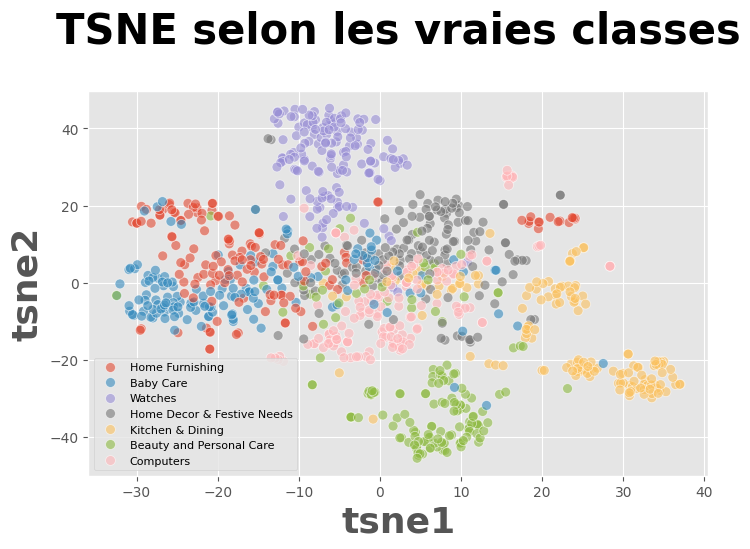

In [11]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["main_category"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 8}) 

plt.show()

Nous pouvons voir que certains catégories sont visuellement plus séparées que d'autres. En effet les catégories "Beauty and Personnal Care" ainsi que "Watches" sont bien séparées des autres points.

Pour les autres catégories, la séparation est moins clair. Peut-être a cause de la sous catégorie

<h2 id='24'>2.4 Classification non-supervisée des features</h2>

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7)
kmeans.fit(X_tsne)

KMeans(n_clusters=7)

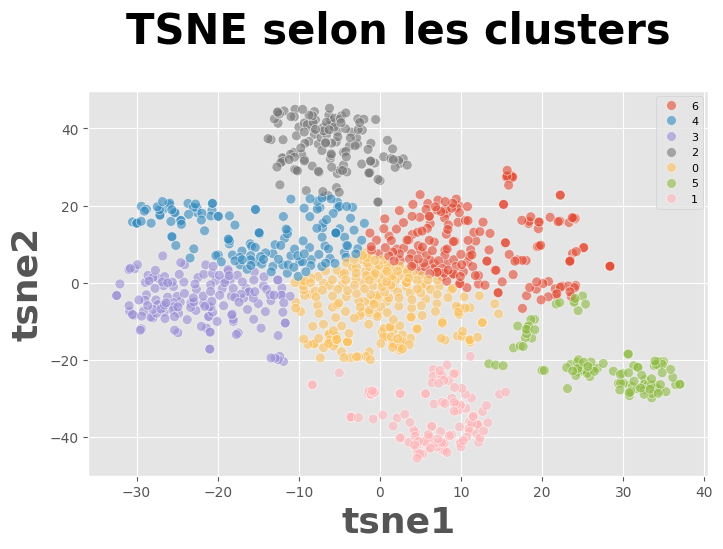

ARI : 0.39


In [13]:
df_tsne["cluster"] = kmeans.labels_
df_tsne["cluster"] = df_tsne["cluster"].astype(str)

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 8}) 

plt.show()


ari = adjusted_rand_score(df_tsne["class"], df_tsne["cluster"])
print(f"ARI : {ari:.2f}")

<h1 id='30'>3. Extraction des features avec SIFT</h1>

<h2 id='31'>3.1 Chargement du modèle SIFT</h2>

In [ ]:
import cv2
sift = cv2.xfeatures2d.SIFT_create(100)

<h2 id='32'>3.2 Extraction des features avec SIFT</h2>

In [ ]:
# identification of key points and associated descriptors
from time import perf_counter
sift_keypoints = []
start = perf_counter()

for i, path in enumerate(df['image']):
    if i % 100 == 0:
        print(f"Extracting features of image {i}")

    image = cv2.imread(image_path+path, 0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    des = des[:100]
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

elapsed = round(perf_counter() - start)
print(f"temps de traitement SIFT descriptor : {elapsed} secondes")

Extracting features of image 0
Extracting features of image 100
Extracting features of image 200
Extracting features of image 300
Extracting features of image 400
Extracting features of image 500
Extracting features of image 600
Extracting features of image 700
Extracting features of image 800
Extracting features of image 900
Extracting features of image 1000

Nombre de descripteurs :  (105000, 128)
temps de traitement SIFT descriptor : 349.328690 secondes


In [35]:
len_des = [len(d) for d in sift_keypoints]

d_100 = [d for d in len_des if d == 100]
d_not = [d for d in len_des if d != 100]

print(len(d_100))
print(len(d_not))

1050
0


In [ ]:
from sklearn.cluster import MiniBatchKMeans

# Determination number of clusters
start = perf_counter()

k = int(len(sift_keypoints_all) ** (1/2))
print(f"Nombre de clusters estimés : {k}")
print(f"Création de {k} clusters de descripteurs ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

elapsed = perf_counter() - start
print(f"temps de traitement kmeans : {elapsed:.2f} secondes")

Nombre de clusters estimés : 324
Création de 324 clusters de descripteurs ...
temps de traitement kmeans : 1 secondes


In [ ]:
# Creation of histograms (features)
start = perf_counter()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

elapsed = perf_counter() - start
print(f"temps de création histogrammes : {elapsed:.2f} secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes : 3 secondes


<h2 id='33'>3.3 Réduction des dimensions</h2>

In [41]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 324)
Dimensions dataset après réduction PCA :  (1050, 281)


In [42]:
tsne = TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["main_category"]
print(df_tsne.shape)

c:\Users\apetit\anaconda3\envs\flipkart\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(1050, 3)


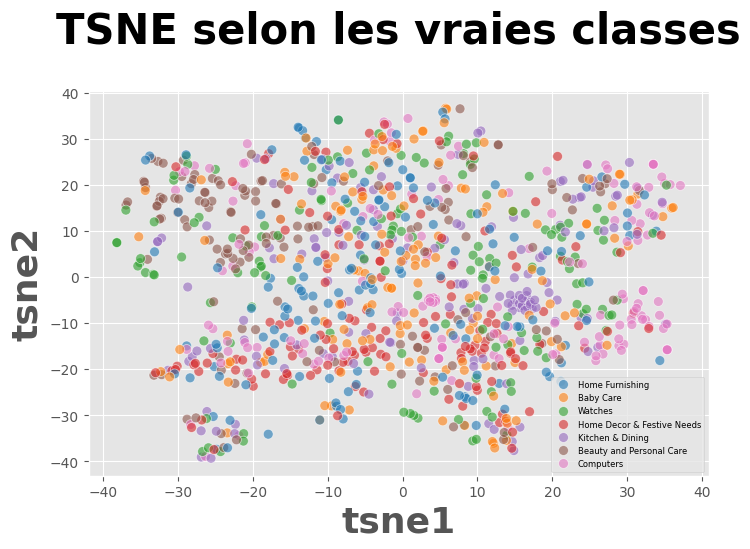

In [48]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 6}) 

plt.show()

<h2 id='34'>3.4 Classification non-supervisée des features</h2>

In [49]:
cls = KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


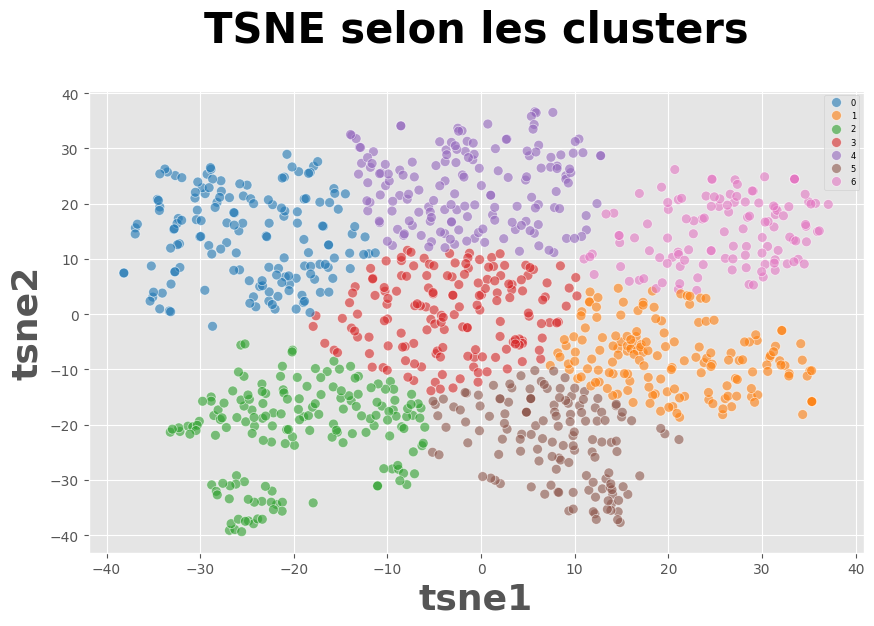

ARI : 0.043


In [50]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 6}) 

plt.show()

labels = df["main_category"]
print(f"ARI : {adjusted_rand_score(labels, cls.labels_):.3f}")

L'utilisation de SIFT pour séparer les catégories montre plus de limite que l'extraction des features avec un CNN pré-entrainé. Il est donc préférable d'utiliser ce type de modèle pour déterminer les catégories des articles

<h1 id='40'>4. Conclusion</h1>

L'extraction des features images semble impossible avec un algorithme comme SIFT.

Les résultats sont meilleurs en extrayant les features grâce à un CNN mais le score actuel ne permet pas de classer tous les produits de manière automatique.